In [2]:
import numpy as np
import emcee
import os
from tqdm import tqdm
import symbolic_pofk.syren_new as syren_new

In [3]:
# Grid configuration
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Parameter ranges
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)   # h
param_ranges = [param_1_range, param_2_range]

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

# MCMC configuration
MCMC_CONFIG = {
    'num_samples': 3000,    # samples per walker
    'warmup_steps': 500,     # burn-in steps
    'num_chains': 4          # number of walkers
}

# Test point configuration
N_RADII = 20
N_ANGLES = 30

# Output directory
OUTPUT_DIR = "/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid


In [4]:
# Forward model and likelihood functions

def forward_model_deterministic(theta):
    """
    Deterministic forward model: theta -> P_theory(k)
    Returns noiseless theoretical power spectrum

    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_theory: theoretical power spectrum (no noise)
    """
    Om, h = theta

    # Fixed cosmological parameters
    As = 2.105  # 10^9 A_s
    Ob = 0.02242 / h ** 2
    ns = 0.9665
    w0 = -1.0
    wa = 0.0
    mnu = 0.0

    # Get theoretical power spectrum (no noise)
    pk_syren_theory = syren_new.pnl_new_emulated(
        kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
    )

    return pk_syren_theory


def compute_cosmic_variance_std(P_theory):
    """
    Compute cosmic variance uncertainties for power spectrum

    Args:
        P_theory: theoretical power spectrum
    Returns:
        std_mode: standard deviation per k-bin
    """
    var_single = np.abs(P_theory)**2
    Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
    var_mode = var_single * 2 / Nk
    std_mode = np.sqrt(var_mode)
    return std_mode


def log_prior(theta):
    """
    Log prior probability (Normal distributions)

    Args:
        theta: [Om, h] parameters
    Returns:
        log_prior: log prior probability
    """
    Om, h = theta

    # Normal prior for Om
    log_prior_Om = -0.5 * ((Om - param_1_mean) / param_1_std)**2

    # Normal prior for h
    log_prior_h = -0.5 * ((h - param_2_mean) / param_2_std)**2

    return log_prior_Om + log_prior_h


def log_likelihood(theta, x_obs):
    """
    Log likelihood function

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_likelihood: log likelihood value
    """
    # Forward model
    P_theory = forward_model_deterministic(theta)

    # Noise model
    std_mode = compute_cosmic_variance_std(P_theory)

    # Gaussian likelihood
    log_like = -0.5 * np.sum(((x_obs - P_theory) / std_mode)
                             ** 2) - np.sum(np.log(std_mode))

    return log_like


def log_probability(theta, x_obs):
    """
    Log posterior probability

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_posterior: log posterior probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, x_obs)


def run_mcmc_inference(x_obs, num_samples=1000, warmup_steps=500, num_chains=4,
                      verbose=False):
    """
    Run MCMC inference using emcee sampler

    Args:
        x_obs: observed power spectrum data (numpy array)
        num_samples: number of MCMC samples per chain
        warmup_steps: number of warmup steps
        num_chains: number of parallel walkers
        verbose: whether to print progress

    Returns:
        samples: dictionary of parameter samples
        sampler: emcee sampler object for diagnostics
    """
    # Ensure x_obs is numpy array
    if not isinstance(x_obs, np.ndarray):
        x_obs = np.array(x_obs)

    # Initialize walkers with random positions within prior range
    pos = np.random.rand(num_chains, 2)
    pos[:, 0] = pos[:, 0] * \
        (param_1_range[1] - param_1_range[0]) + param_1_range[0]  # Om
    pos[:, 1] = pos[:, 1] * \
        (param_2_range[1] - param_2_range[0]) + param_2_range[0]  # h

    # Set up sampler
    sampler = emcee.EnsembleSampler(
        num_chains, 2, log_probability, args=(x_obs,))

    if verbose:
        print(f"Running MCMC: {num_samples} samples, {warmup_steps} warmup, {num_chains} walkers")

    # Run warmup
    state = sampler.run_mcmc(pos, warmup_steps)
    sampler.reset()

    # Run production
    sampler.run_mcmc(state, num_samples)

    # Extract samples
    chain = sampler.get_chain(flat=True)
    samples_np = {
        'Om': chain[:, 0],
        'h': chain[:, 1]
    }

    return samples_np, sampler


def simulator(theta):
    """
    Simulator with noise: theta -> P(k) with cosmic variance

    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_noisy: power spectrum with cosmic variance noise
    """
    # Get noiseless prediction
    P_theory = forward_model_deterministic(theta)

    # Get noise level
    std_mode = compute_cosmic_variance_std(P_theory)

    # Add noise
    P_noisy = P_theory + std_mode * np.random.randn(*P_theory.shape)

    return P_noisy

In [5]:
def create_test_points(n_radii=20, n_angles=30):
    """
    Create test points on concentric circles in parameter space.

    Args:
        n_radii: number of radii to sample
        n_angles: number of angles per circle

    Returns:
        test_points: array of shape (n_points, 2) with [Om, h] values
        radii: array of radii corresponding to each test point
    """
    # Calculate prior center and max radius
    prior_center = np.array([
        (param_1_range[0] + param_1_range[1]) / 2,  # Om center
        (param_2_range[0] + param_2_range[1]) / 2   # h center
    ])

    # Max radius is distance to corner
    max_radius = np.sqrt(
        ((param_1_range[1] - param_1_range[0]) / 2) ** 2 +
        ((param_2_range[1] - param_2_range[0]) / 2) ** 2
    )

    # Start with center point
    test_points = [prior_center.copy()]
    radii = [0.0]

    # Create concentric circles
    for radius in np.linspace(0.2 * max_radius, 0.9 * max_radius, n_radii):
        for angle in np.linspace(0, 2*np.pi, n_angles, endpoint=False):
            x = prior_center[0] + radius * np.cos(angle)
            y = prior_center[1] + radius * np.sin(angle)

            # Only keep points within parameter bounds
            if (param_ranges[0][0] <= x <= param_ranges[0][1] and
                param_ranges[1][0] <= y <= param_ranges[1][1]):
                test_points.append([x, y])
                radii.append(radius)

    return np.array(test_points), np.array(radii)

In [6]:
# Generate test points
test_points, radii = create_test_points(n_radii=N_RADII, n_angles=N_ANGLES)

n_test_points = len(test_points)
print(f"Generated {n_test_points} test points")

# Save test points metadata
np.save(os.path.join(OUTPUT_DIR, "test_points.npy"), test_points)
np.save(os.path.join(OUTPUT_DIR, "radii.npy"), radii)
print(f"Saved test points to: {OUTPUT_DIR}/test_points.npy")
print(f"Saved radii to: {OUTPUT_DIR}/radii.npy")

Generated 475 test points
Saved test points to: /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid/test_points.npy
Saved radii to: /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid/radii.npy


In [7]:
# extract the 19th test point as an example
example_index = 19
example_theta = test_points[example_index]
print(f"Example test point (index {example_index}): Om={example_theta[0]}, h={example_theta[1]}")

x_obs = simulator(example_theta)

# Run MCMC inference
samples, sampler = run_mcmc_inference(
    x_obs,
    num_samples=MCMC_CONFIG['num_samples'],
    warmup_steps=MCMC_CONFIG['warmup_steps'],
    num_chains=MCMC_CONFIG['num_chains'],
    verbose=False
)

Example test point (index 19): Om=0.30381966011250106, h=0.6582442949541505


In [ ]:
# Run MCMC for each test point
print(f"\nRunning MCMC for {n_test_points} test points...")
print("="*80)

# continue from idx = 472

for idx, theta_test in enumerate(tqdm(test_points, desc="MCMC Progress")):
    if idx < 472:
        continue
    # Generate observed data at this test point
    x_obs = simulator(theta_test)

    # Run MCMC inference
    samples, sampler = run_mcmc_inference(
        x_obs,
        num_samples=MCMC_CONFIG['num_samples'],
        warmup_steps=MCMC_CONFIG['warmup_steps'],
        num_chains=MCMC_CONFIG['num_chains'],
        verbose=False
    )

    # Convert to array format
    samples_array = np.column_stack([samples['Om'], samples['h']])

    # Save posterior samples
    output_file = os.path.join(OUTPUT_DIR, f"theta_{idx:04d}.npy")
    np.save(output_file, samples_array)

print(f"Saved {n_test_points} posterior sample files to: {OUTPUT_DIR}/")



Running MCMC for 475 test points...


MCMC Progress: 100%|██████████| 475/475 [00:16<00:00, 28.04it/s]

Saved 475 posterior sample files to: /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/circle_grid/


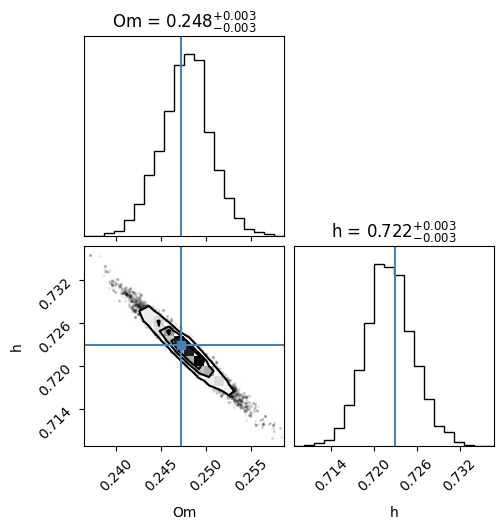

In [87]:
example_index = 472
example_theta = test_points[example_index]

# import theta of index
samples = np.load(os.path.join(OUTPUT_DIR, f"theta_{example_index:04d}.npy"))

import corner
import matplotlib.pyplot as plt
# Create a corner plot
corner.corner(
    samples,
    labels=["Om", "h"],
    truths=example_theta,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.show()